In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

In [2]:
NUM_CLASSES = 3
NUM_PTS = 1000

t = np.linspace(0, np.pi / 4, NUM_PTS)

data = [
    np.stack(
        [
            t * np.sin( (2 * np.pi / NUM_CLASSES) * (2 * t + k) ) + np.random.randn(NUM_PTS) * 0.05,
            t * np.cos( (2 * np.pi / NUM_CLASSES) * (2 * t + k) ) + np.random.randn(NUM_PTS) * 0.05,
        ], axis = 1
    ) for k in range(NUM_CLASSES)
]

In [3]:
labels = ['b', 'g', 'r']    # Colors - which will be easier to visualize in plots

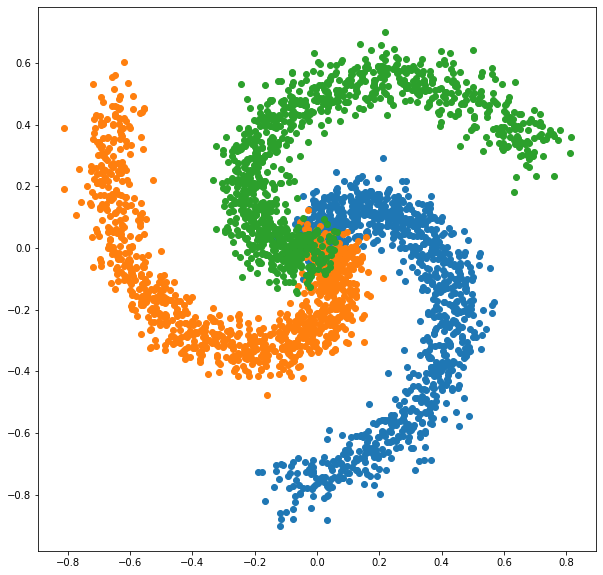

In [4]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i in range(NUM_CLASSES):
    ax.scatter(data[i][:, 0], data[i][:, 1], label = labels[i])
plt.show()
plt.close(fig)

Clearly, the data is not linearly separable

In [5]:
import torch
from tqdm import tqdm

In [6]:
CUDA = torch.cuda.is_available()
device = torch.device('cuda' if CUDA else 'cpu')

In [7]:
color_to_numeric = {'r': 0, 'g': 1, 'b': 2}

numerical_labels = [0] * len(data[0]) + [1] * len(data[1]) + [2] * len(data[2])
numerical_labels = np.asarray(numerical_labels)

In [8]:
data = np.concatenate(data, axis = 0)
data.shape

(3000, 2)

In [9]:
dset = torch.utils.data.TensorDataset(
    torch.tensor(data, dtype=torch.float32),
    torch.tensor(numerical_labels, dtype=torch.long)
)

In [10]:
dloader = torch.utils.data.DataLoader(
    dset, batch_size=16, shuffle=True, num_workers=2
)

In [11]:
net = torch.nn.Sequential(
    torch.nn.Linear(2, 100),
    torch.nn.Linear(100, 2),
    torch.nn.Linear(2, NUM_CLASSES)
)

net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

criterion = torch.nn.CrossEntropyLoss()

In [12]:
view_output = [None]

def hook_fn(module, input, output):
    view_output[0] = output.detach().cpu().numpy()

hook = net[-2].register_forward_hook(hook_fn)
# call hook.remove() to remove

Notice that we havve iintentionally not put any non-linearities in this network.

This is to see how such a network performms on non-linear data

In [13]:
NUM_EPOCHS = 1000

In [14]:
PLOT_AFTER = 10

Epoch: 990 	 Loss: 0.486883282661438


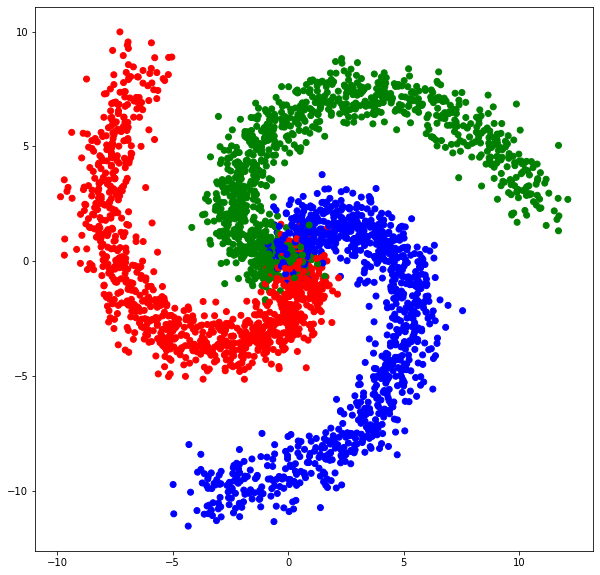

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:20<00:00,  3.12it/s]


In [15]:
loop = tqdm(range(NUM_EPOCHS))

for epoch in loop:
    transformed_inputs = np.zeros((0, 2))
    labels = np.zeros((0,), dtype=np.int64)

    for x, y in dloader:
        x = x.to(device)
        y = y.to(device)

        y_pred = net(x)

        optimizer.zero_grad()

        loss = criterion(y_pred, y)
        loss.backward()
        
        # Get activation of the second last layer
        transformed_inputs = np.append(transformed_inputs, view_output[0], axis=0)
        labels = np.append(labels, y.detach().cpu().numpy(), axis=0)

        optimizer.step()

    if epoch % PLOT_AFTER == 0:
        clear_output(wait=True)
        print(f'Epoch: {epoch} \t Loss: {loss.item()}')

        space_transform_fig = plt.figure(figsize=(10, 10))
        colors = [['r', 'g', 'b'][i] for i in labels]
        plt.scatter(transformed_inputs[:, 0], transformed_inputs[:, 1], c=colors)
        plt.show()

In [16]:
net = torch.nn.Sequential(
    torch.nn.Linear(2, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 2),
    torch.nn.Linear(2, NUM_CLASSES)
)

net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

criterion = torch.nn.CrossEntropyLoss()

In [17]:
view_output = [None]

def hook_fn(module, input, output):
    view_output[0] = output.detach().cpu().numpy()

hook = net[-2].register_forward_hook(hook_fn)
# call hook.remove() to remove

Epoch: 990 	 Loss: 0.19341225922107697


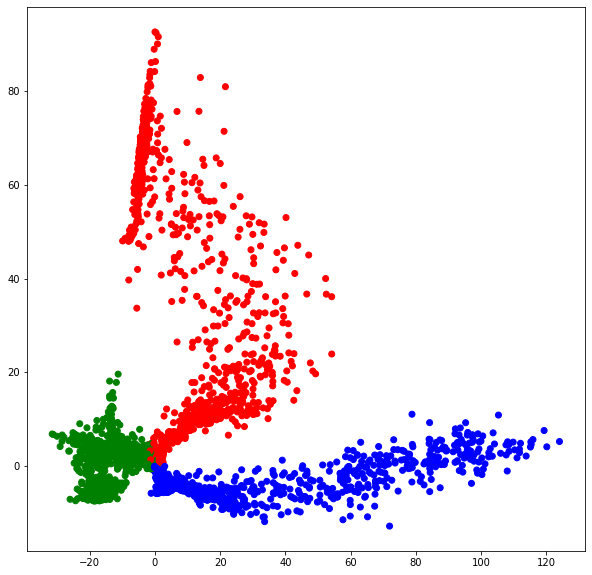

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:25<00:00,  3.07it/s]


In [18]:
loop = tqdm(range(NUM_EPOCHS))

for epoch in loop:
    transformed_inputs = np.zeros((0, 2))
    labels = np.zeros((0,), dtype=np.int64)

    for x, y in dloader:
        x = x.to(device)
        y = y.to(device)

        y_pred = net(x)

        optimizer.zero_grad()

        loss = criterion(y_pred, y)
        loss.backward()
        
        # Get activation of the second last layer
        transformed_inputs = np.append(transformed_inputs, view_output[0], axis=0)
        labels = np.append(labels, y.detach().cpu().numpy(), axis=0)

        optimizer.step()

    if epoch % PLOT_AFTER == 0:
        clear_output(wait=True)
        print(f'Epoch: {epoch} \t Loss: {loss.item()}')

        space_transform_fig = plt.figure(figsize=(10, 10))
        colors = [['r', 'g', 'b'][i] for i in labels]
        plt.scatter(transformed_inputs[:, 0], transformed_inputs[:, 1], c=colors)
        plt.show()